<a href="https://colab.research.google.com/github/muajnstu/Multi-Class-Classification-of-YouTube-Videos-Using-A-BERT-enhanced-Machine-Learning-approach/blob/main/DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nlpaug
!pip install ktrain
!pip install tensorflow
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 32.5 MB/s eta 0:00:00
  Created wheel for ktrain: filename=ktrain-0.41.4-py3-none-any.whl size=25316931 sha256=5ce36b94512273114ad3d673b10bcc9a9194ce37bb9ad5b8c4faf18897f7b61d
  Stored in directory: /root/.cache/pip/wheels/a6/b9/88/364e4ea6461e9f1feee834bfc2f15b92edc62600e08e3d3f5f
  Cre

In [ ]:

# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import nlpaug.augmenter.word as naw

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/muajnstu/ML-Datasets/refs/heads/main/Youtube%20Video%20Dataset.csv')

# Map category labels to integers
df["Category"] = df["Category"].map({
    "travel blog": 0,
    "Science&Technology": 1,
    "Food": 2,
    "Art&Music": 3,
    "manufacturing": 4,
    "History": 5
})

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Combine Title and Description into one text field
df['processed_text'] = df['Title'] + " " + df['Description']

# Drop unneeded columns
df.drop(columns=['Title', 'Description', 'Videourl'], inplace=True)

# Extract meaningful part using regex
def extract_txt(text):
    text = str(text)
    match = re.search(r"(?<=\s\-\s). *", text)
    return match.group(0) if match else text

df['processed_text'] = df['processed_text'].apply(extract_txt)

# Basic text cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\n', ' ', text)
    return text

df['processed_text'] = df['processed_text'].apply(clean_text)

# Rename for simplicity (optional)
df.rename(columns={'processed_text': 'text'}, inplace=True)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    df['text'], df['Category'], test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Load tokenizer for DistilBERT
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Function to tokenize texts
def encode_texts(tokenizer, texts, max_length=256):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks)

# Tokenize each split
train_input_ids, train_attention_masks = encode_texts(tokenizer, X_train)
val_input_ids, val_attention_masks = encode_texts(tokenizer, X_val)
test_input_ids, test_attention_masks = encode_texts(tokenizer, X_test)

# Final label tensors
y_train = tf.convert_to_tensor(y_train.values)
y_val = tf.convert_to_tensor(y_val.values)
y_test = tf.convert_to_tensor(y_test.values)

# Model initialization using DistilBERT (adjusted to 6 classes)
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)

# Model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Model training with validation data
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    batch_size=20,
    validation_data=([val_input_ids, val_attention_masks], y_val),
    epochs=5,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([test_input_ids, test_attention_masks], y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
449/449 [==============================] - 252s 503ms/step - loss: 1.0359 - accuracy: 0.6239 - val_loss: 0.8197 - val_accuracy: 0.6860
Epoch 2/5
449/449 [==============================] - 229s 511ms/step - loss: 0.7907 - accuracy: 0.6928 - val_loss: 0.7878 - val_accuracy: 0.6976
Epoch 3/5
449/449 [==============================] - 229s 511ms/step - loss: 0.7625 - accuracy: 0.7007 - val_loss: 0.8029 - val_accuracy: 0.6833
Epoch 4/5
449/449 [==============================] - 229s 510ms/step - loss: 0.7541 - accuracy: 0.7053 - val_loss: 0.7841 - val_accuracy: 0.6931
Epoch 5/5
36/36 [==============================] - 10s 268ms/step - loss: 0.7996 - accuracy: 0.6845
Test Loss: 0.799644947052002
Test Accuracy: 0.6844919919967651


36/36 [==============================] - 22s 524ms/step
Confusion Matrix:
[[165  19   9   5   5   1]
 [  2 207   2   2   2   5]
 [ 11   9 162   4   4   1]
 [  6   9   3 154   0   1]
 [  5  11   1   0 143   2]
 [  2  14   2   3   2 149]]
Precision: 0.8794
Recall: 0.8734
F1 Score: 0.8741


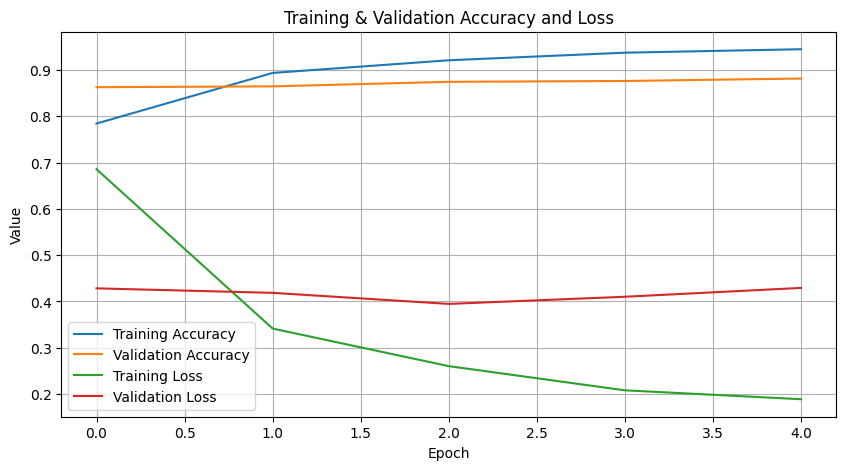

In [ ]:
# At the beginning of your script, add these imports
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test set
predictions = model.predict([test_input_ids, test_attention_masks])[0]
predicted_classes = np.argmax(predictions, axis=1)

# Convert y_test to numpy array
y_test_np = np.array(y_test).astype('int32')

# Calculate confusion matrix and performance metrics
cm = confusion_matrix(y_test_np, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_np, predicted_classes, average='weighted')

# Print metrics
print(f'Confusion Matrix:\n{cm}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plotting training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


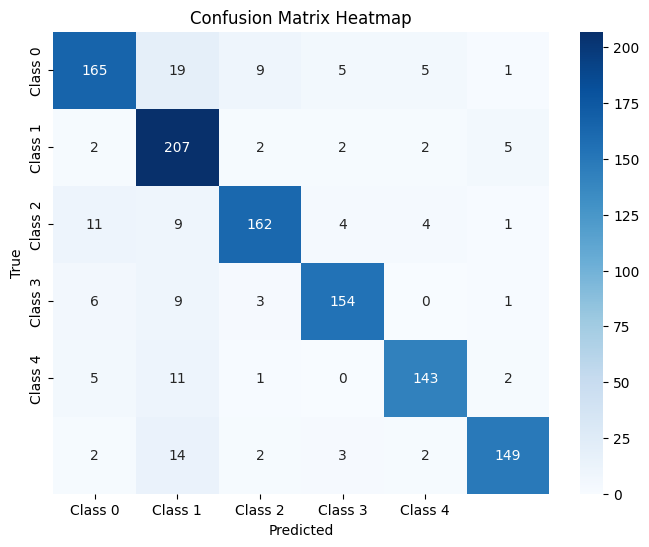

In [ ]:
y_test_np = np.array(y_test).astype('int32')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Calculate confusion matrix
cm = confusion_matrix(y_test_np, predicted_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


36/36 [==============================] - 19s 527ms/step
Metrics for Class 0:
Precision: 0.8638743455497382
Recall: 0.8088235294117647
F1 Score: 0.8354430379746836
Accuracy: 0.9420677361853832



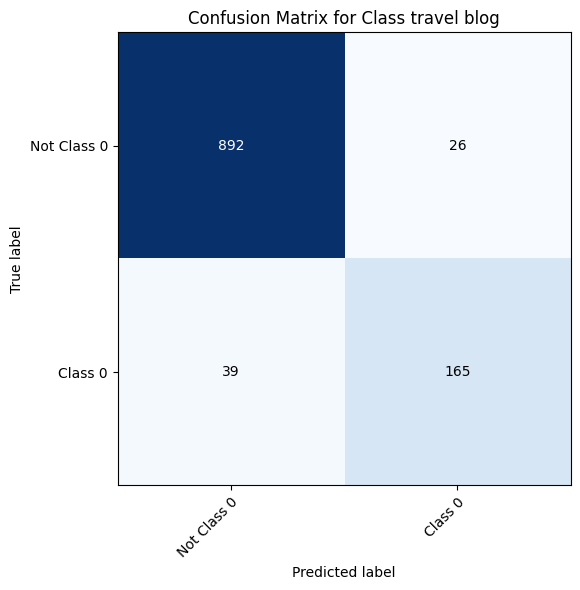

Metrics for Class 1:
Precision: 0.7695167286245354
Recall: 0.9409090909090909
F1 Score: 0.8466257668711656
Accuracy: 0.9331550802139037



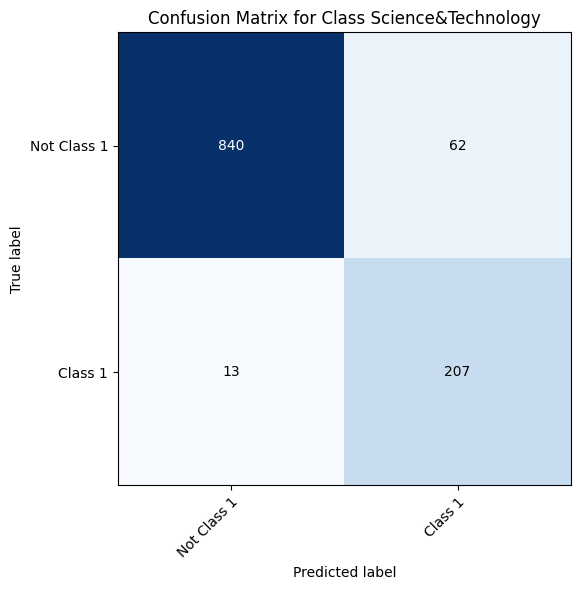

Metrics for Class 2:
Precision: 0.9050279329608939
Recall: 0.8481675392670157
F1 Score: 0.8756756756756757
Accuracy: 0.9590017825311943



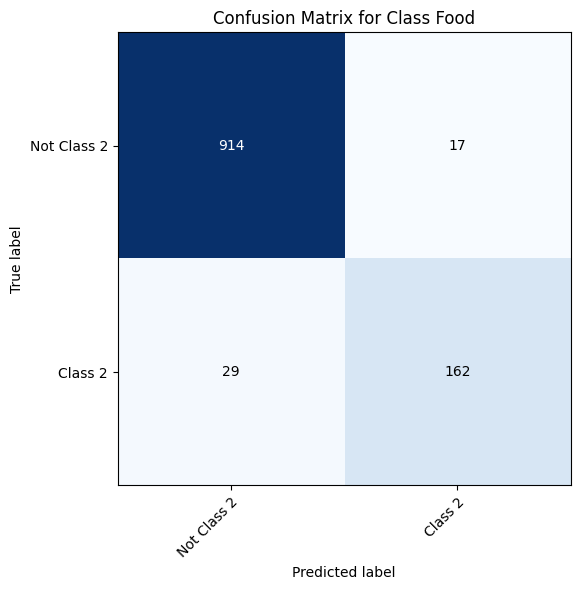

Metrics for Class 3:
Precision: 0.9166666666666666
Recall: 0.8901734104046243
F1 Score: 0.9032258064516129
Accuracy: 0.9705882352941176



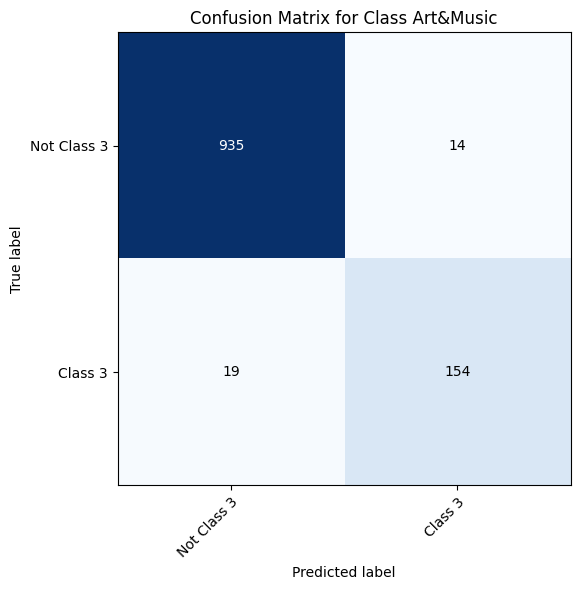

Metrics for Class 4:
Precision: 0.9166666666666666
Recall: 0.8827160493827161
F1 Score: 0.89937106918239
Accuracy: 0.9714795008912656



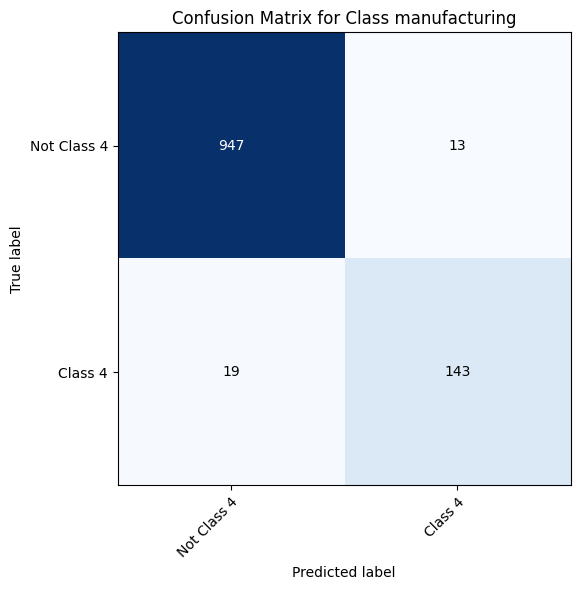

Metrics for Class 5:
Precision: 0.9371069182389937
Recall: 0.8662790697674418
F1 Score: 0.9003021148036254
Accuracy: 0.9705882352941176



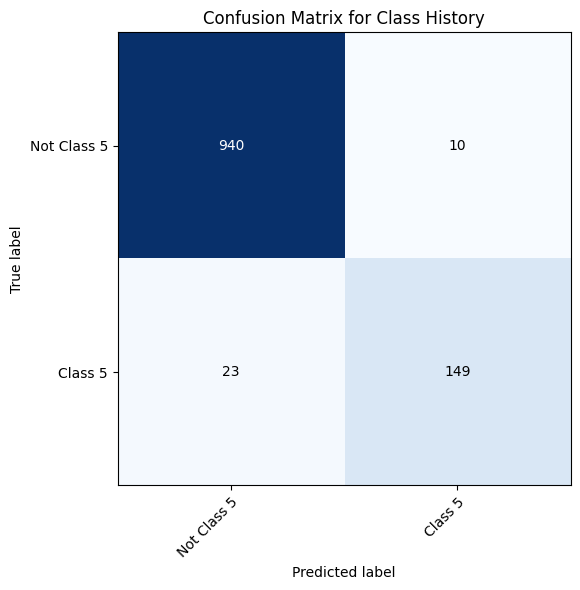

In [ ]:
# Predictions
test_predictions = model.predict([test_input_ids, test_attention_masks])
test_predictions = np.argmax(test_predictions.logits, axis=1)

# Define class_names based on your dataset
class_names = ["travel blog", "Science&Technology", "Food", "Art&Music", "manufacturing", "History"]

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_index, class_names):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(2),
           yticks=np.arange(2),
           xticklabels=[f'Not Class {class_index}', f'Class {class_index}'],
           yticklabels=[f'Not Class {class_index}', f'Class {class_index}'],
           title=f'Confusion Matrix for Class {class_names[class_index]}',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# Display metrics and confusion matrix for each class
for class_index in range(len(class_names)):
    true_binary = (y_test == class_index)
    pred_binary = (test_predictions == class_index)
    conf_matrix = confusion_matrix(true_binary, pred_binary, labels=[False, True])

    precision, recall, f1, _ = precision_recall_fscore_support(true_binary, pred_binary, labels=[False, True])

    # Calculate accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    print(f"Metrics for Class {class_index}:")
    print(f"Precision: {precision[1]}")
    print(f"Recall: {recall[1]}")
    print(f"F1 Score: {f1[1]}")
    print(f"Accuracy: {accuracy}\n")

    plot_confusion_matrix(conf_matrix, class_index, class_names)

# **ROC-AUC**

36/36 [==============================] - 20s 544ms/step


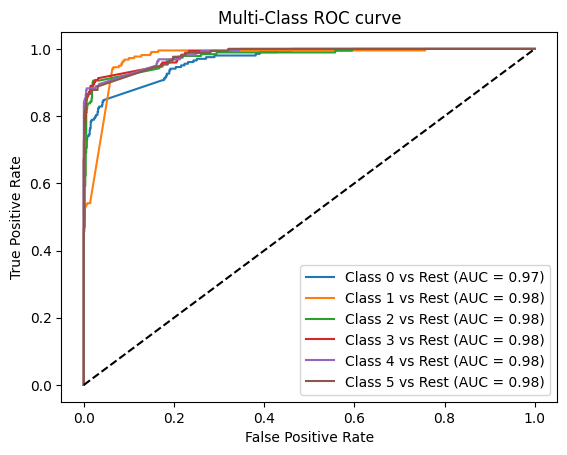

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Predict probabilities
pred_probabilities = model.predict([test_input_ids, test_attention_masks])
preds = tf.nn.softmax(pred_probabilities.logits).numpy()

# For multi-class, calculate ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()
n_class = len(class_names)

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(to_categorical(y_test, num_classes=n_class)[:,i], preds[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='-', label=f'Class {i} vs Rest (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC curve')
plt.legend(loc='best')
plt.show()
